# TW Analysis of the Scavenge Feature

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

**History Log**
* 2021-05-23: V1.0

## Introduction

Scavenging performance (loot/time) is fully determined by two variables:
1. Scavenge level $l \in \{1,2,3,4\}$
2. Total loot capacity $c \in \mathbb{N}$

Total loot capacity is the sum of loot capacities for the units deployed for a scavenge run.

**Example:** 5 spears and 10 swords make for a total loot capacity $c = 5 \cdot 25 + 10 \cdot 15 = 275$

**Loot factor** is a function of scavenge level:

$$
LF(l) = 
\begin{cases}
0.1 &\text{if l=1} \\
0.25 &\text{if l=2} \\
0.5 &\text{if l=3} \\
0.75 &\text{if l=4} \\
\end{cases}
$$

**Scavenge return** (resources) is a function of scavenge level and loot capacity:

$$
R(l,c) = c \cdot LF(l)
$$

**Scavenge duration** (in seconds) is a function of scavenge level and loot capacity:

$$
T(l,c) = (((LF(l) \cdot c)^{2} \cdot 100)^{d_1} + d_2) \cdot d_3
$$

$d_1$ (duration exponent), $d_2$ (duration initial seconds) and $d_3$ (duration factor) are constants specified for every world. The constants can be found by looking at the scavenge screen's page source and searching for `duration_exponent`, `duration_initial_seconds`, `duration_factor`.

**Scavenge performance** (return/time) is a function of scavenge level and loot capacity:

$$
P(l,c) = \frac{R(l,c)}{T(l,c)}
$$

The following notations are equivalent:
* $R_1(c) \iff R(1,c)$
* $T_1(c) \iff T(1,c)$
* $P_1(c) \iff P(1,c)$

The following questions can be answered using previously defined functions (10 spears have a total loot capacity of 250):

**Question:** How much resources are earned when deploying 10 spears to level 2 scavenge (humble haulers)? 

**Answer:** $R_2(250)$ (divide the result by 3 to get the return for wood, clay and iron respectively)


**Question:** How long does it take to finish a level 4 scavenge (great gatherers) with 10 spears? 

**Answer:** $T_4(250)$ seconds

**Question:** How much resources are earned *per second* when deploying 10 spears to level 3 scavenge (clever collectors)? 

**Answer**: $P_3(250)$ resources per second

**Question:** How much resources are earned *per hour* when deploying 10 spears to level 3 scavenge (clever collectors)? 

**Answer**: $P_3(250) \cdot 60 \cdot 60$ resources per hour

**Question:** How much resources are earned per second when simultaneously deploying 10 spears to level 3 scavenge and 10 spears to level 4 scavenge? 

**Answer**: $P_3(250) + P_4(250)$ resources per second

## Problem Statement

Given loot capacity $c$, one may pose the question "how should $c$ be distributed to the four scavenge levels to reach maximum performance?"

**Total performance** $J$ can be formulated as:

$$
J(c_1,c_2,c_3,c_4) = P_1(c_1) + P_2(c_2) + P_3(c_3) + P_4(c_4)
$$

**Problem Statement:** Maximize $J$ subject to the constraints $c \ge c_1 + c_2 + c_3 + c_4$ and $c_1,c_2,c_3,c_4 \ge 0$.

The problem is equivalent to minimizing $-J$. Instead of solving the problem analytical, library functions such as [scipy.optimizie.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) can be used to find the minimum algorithmically. Various minimization methods are supported and the [COBYLA](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html#optimize-minimize-cobyla) method allows for minimizing constrained functions.

## Implementation

In [2]:
def return_(caps, levels=[1,2,3,4]):
    """
    Calculate scavenge return (resources)
    
    Parameters
    ----------
    caps : list of floats
        the scavenge capacities
        if levels=[1,2,3,4], then `caps` contains capacities
        for level 1,2,3,4 scavenge
    levels : list of ints
        assigns the scavenge level to each capacity in `caps`
        caps[0] is the capacity for scavenge levels[0]
        must be of the same size as `caps`
        level can be any of [1,2,3,4]

    Returns
    -------
    {ndarray} of floats
        the return (resources) for each level
    """
    LF = np.array([0.1, 0.25, 0.5, 0.75])
    levels = np.array(levels)-1
    return np.array(caps)*LF[levels]

def duration(caps, d1, d2, d3, levels=[1,2,3,4]):
    """
    Calculate scavenge duration (seconds)
    
    Parameters
    ----------
    caps : list of floats
        the scavenge capacities
        if levels=[1,2,3,4], then `caps` contains capacities
        for level 1,2,3,4 scavenge
    levels : list of ints
        assigns a scavenge level to each capacity in `caps`
        caps[0] is the capacity for scavenge levels[0]
        must be of the same size as `caps`
        level can be any of [1,2,3,4]
    d1 : float
        duration exponent
    d2 : float
        duration initial seconds
    d3 : float
        duration factor
        
    Returns
    -------
    {ndarray} of floats
        the duration (seconds) of scavenge runs for each level
    """
    R = return_(caps, levels)
    return ((R*R*100)**d1 + d2)*d3

def performance(caps, d1, d2, d3, levels=[1,2,3,4]):
    """
    Calculate scavenge performance (return/second)
    
    Parameters
    ----------
    caps : list of floats
        the scavenge capacities
        if levels=[1,2,3,4], then `caps` contains capacities
        for level 1,2,3,4 scavenge
    levels : list of ints
        assigns the scavenge level to each capacity in `caps`
        caps[0] is the capacity for scavenge levels[0]
        must be of the same size as `caps`
        level can be any of [1,2,3,4]
    d1 : float
        duration exponent
    d2 : float
        duration initial seconds
    d3 : float
        duration factor
        
    Returns
    -------
    {ndarray} of floats
        the performance (resources/second) for each level
    """
    return return_(caps, levels)/duration(caps, d1, d2, d3, levels)

def maximize_performance(c, d1, d2, d3, levels=[1,2,3,4]):
    """
    Find best distribution of capacity `c` for scavenging in `levels` to reach
    maximum performance (resource/second).
    
    Parameters
    ----------
    c : float
        total capacity
    d1 : float
        duration exponent
    d2 : float
        duration initial seconds
    d3 : float
        duration factor
    levels : list of ints
        the levels to take into consideration
        valid levels are any of [1,2,3,4]
    """
    J = lambda caps: -performance(caps, d1, d2, d3, levels).sum()
    nlevels = len(levels)
    
    # create c_i
    x0 = np.array([c/nlevels for i in range(nlevels)])
    
    # constraints for c_i >= 0
    cons = [{'type': 'ineq',
             'fun': lambda x, i=i: x[i]} for i in range(nlevels)]
    # constraint for c >= sum(c_i)
    cons.append({'type': 'ineq',
                 'fun': lambda x: c - x.sum()})

    return minimize(J, x0, method='COBYLA', constraints=cons, options={"maxiter":10_000})

def units_to_cap(units):
    """
    Calculate total loot capacity for a number of `units`.
    
    Parameters
    ----------
    units : dict with str keys (unit name) and float values (amount)
        The amount of units. Keys must be any of:
            ['spear', 'sword', 'axe', 'archer', 'light', 'mounted', 'heavy', 'paladin']
            
    Returns
    -------
    float
        total loot capacity
    """
    caps = {
        'spear':   25,
        'sword':   15,
        'axe':     10,
        'archer':  10,
        'light':   80,
        'mounted': 50,
        'heavy':   50,
        'paladin': 100
    }
    cap = 0
    for unit in units:
        assert unit in caps.keys(), f"invalid unit '{unit}', valid units are {list(caps.keys())}"
        cap += caps[unit] * units[unit]
    return cap

## Performance Comparisons

In the following we'll compare performances of optimal and equal capacity distributions. **Optimal strategy** distributes capacity $c$ to scavenge levels such that perfomance is maximized. **Equal strategy** distributes capacity $c$ equally to scavenge levels.

Moreover, we'll compare performances of using just one level at atime and using multiple levels simultaneously with equal strategy. We'll compute the performance surplus of using level 1 alone versus using levels 1,2 versus using levels 1,2,3 versus using levels 1,2,3,4.

In [3]:
# constants from CH60
d1 = 0.45
d2 = 1800
d3 = 0.7722074897

def optimal_performances(capacities, levels=[1,2,3,4]):
    """
    Returns
    -------
    ndarray of floats
        performances (res/hour) of optimal strategy for every c in `capacities`
    """
    caps  = np.array(capacities)
    performances = []
    nlevels = len(levels)
    for c in caps:
        performances.append(-maximize_performance(c, d1, d2, d3, levels)['fun'])
    return np.array(performances)*3600

def equal_performances(capacities, levels=[1,2,3,4]):
    """
    Returns
    -------
    ndarray of floats
        performances (res/hour) of equal strategy for every c in `capacities`
    """
    caps = np.array(capacities)
    performances = []
    nlevels = len(levels)
    for c in caps:
        performances.append(performance([c/nlevels for i in range(nlevels)], d1, d2, d3, levels).sum())
    return np.array(performances)*3600

def plot_performance_comparison(caps, op_performances, eq_performances, ax, label1=None, label2=None, color=''):
    ax.plot(caps, eq_performances, f'{color}--', label=label1)
    ax.plot(caps, op_performances, f'{color}', label=label2)
    ax.legend()
    ax.set_title('Performances')
    ax.set_xlabel('capacity')
    ax.set_ylabel('resources / hour')
    ax.grid();

def plot_performance_delta(caps, op_performances, eq_performances, ax, label=None, color=''):
    ax.plot(caps, op_performances-eq_performances, color, label=label)
    ax.set_title('Performance Delta')
    ax.set_xlabel('capacity')
    ax.set_ylabel('resources / hour surplus')
    if label is not None:
        ax.legend()
    ax.grid()

In [4]:
%%time
caps_sm = np.arange(100, 10_000, 100)
op_sm_1234, eq_sm_1234 = optimal_performances(caps_sm), equal_performances(caps_sm) 
op_sm_123, eq_sm_123 = optimal_performances(caps_sm, levels=[1,2,3]), equal_performances(caps_sm, levels=[1,2,3])
op_sm_12, eq_sm_12 = optimal_performances(caps_sm, levels=[1,2]), equal_performances(caps_sm, levels=[1,2])

CPU times: user 6.08 s, sys: 184 ms, total: 6.27 s
Wall time: 6.12 s


In [5]:
%%time
caps_lg = np.arange(1000, 100_000, 1_000)
op_lg_1234, eq_lg_1234 = optimal_performances(caps_lg), equal_performances(caps_lg)
op_lg_123, eq_lg_123 = optimal_performances(caps_lg, levels=[1,2,3]), equal_performances(caps_lg, levels=[1,2,3])
op_lg_12, eq_lg_12 = optimal_performances(caps_lg, levels=[1,2]), equal_performances(caps_lg, levels=[1,2])

CPU times: user 27 s, sys: 527 ms, total: 27.5 s
Wall time: 27.1 s


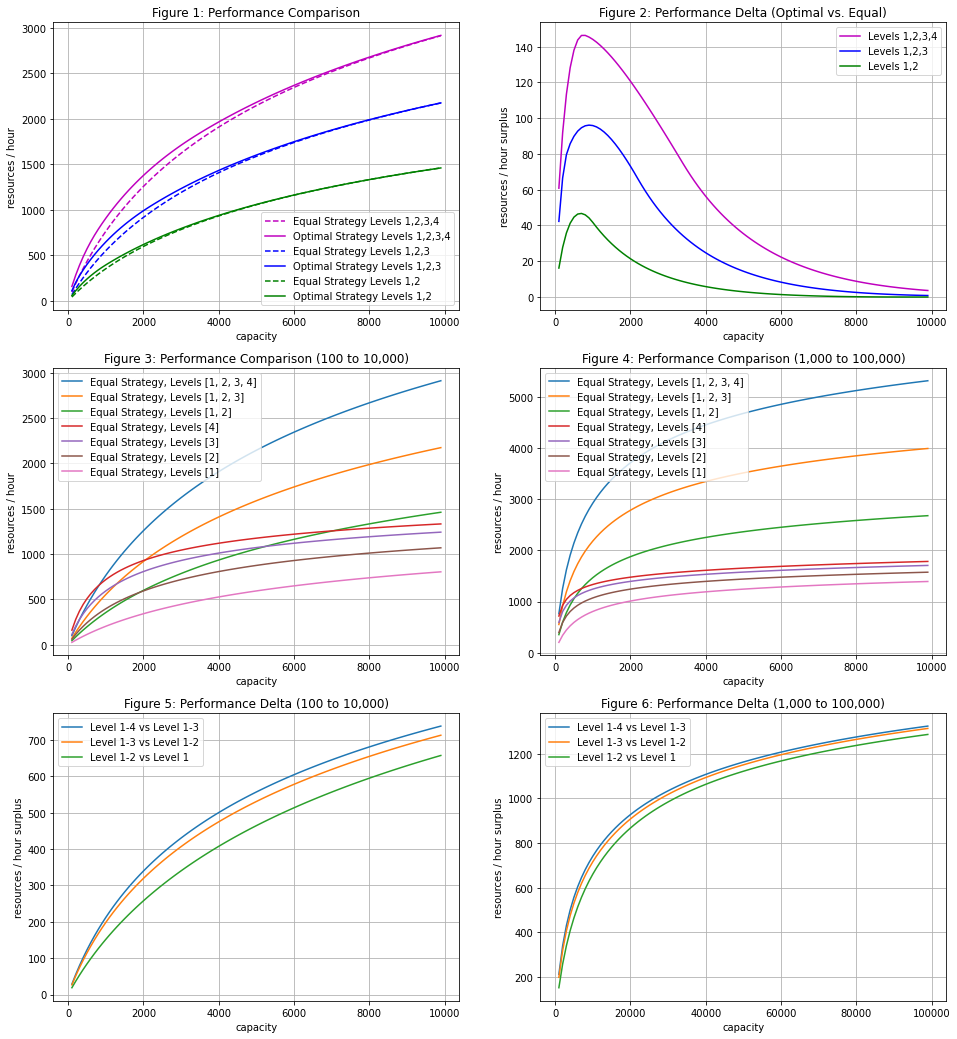

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,18))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

plot_performance_comparison(caps_sm, op_sm_1234, eq_sm_1234, ax1, 
                            label1='Equal Strategy Levels 1,2,3,4', 
                            label2='Optimal Strategy Levels 1,2,3,4',
                            color='m')
plot_performance_comparison(caps_sm, op_sm_123, eq_sm_123, ax1, 
                            label1='Equal Strategy Levels 1,2,3', 
                            label2='Optimal Strategy Levels 1,2,3',
                            color='b')
plot_performance_comparison(caps_sm, op_sm_12, eq_sm_12, ax1, 
                            label1='Equal Strategy Levels 1,2', 
                            label2='Optimal Strategy Levels 1,2',
                            color='g')
ax1.set_title('Figure 1: Performance Comparison')

plot_performance_delta(caps_sm, op_sm_1234, eq_sm_1234, ax2, label=f'Levels 1,2,3,4', color='m')
plot_performance_delta(caps_sm, op_sm_123, eq_sm_123, ax2, label=f'Levels 1,2,3', color='b')
plot_performance_delta(caps_sm, op_sm_12, eq_sm_12, ax2, label=f'Levels 1,2', color='g')
ax2.set_title('Figure 2: Performance Delta (Optimal vs. Equal)');


p = []
levels = [
    [1,2,3,4],
    [1,2,3],
    [1,2],
    [4],
    [3],
    [2],
    [1],
]

for l in levels:
    p_ = equal_performances(caps_sm, levels=l)
    ax3.plot(caps_sm, p_, label=f'Equal Strategy, Levels {l}')
    p_ = equal_performances(caps_lg, levels=l)
    ax4.plot(caps_sm, p_, label=f'Equal Strategy, Levels {l}')

ax3.set_title('Figure 3: Performance Comparison (100 to 10,000)')
ax3.grid()
ax3.legend()
ax3.set_xlabel('capacity')
ax3.set_ylabel('resources / hour')

ax4.set_title('Figure 4: Performance Comparison (1,000 to 100,000)')
ax4.grid()
ax4.legend()
ax4.set_xlabel('capacity')
ax4.set_ylabel('resources / hour')


eq_sm_1 = equal_performances(caps_sm, levels=[1])
plot_performance_delta(caps_sm, eq_sm_1234, eq_sm_123, ax5, label='Level 1-4 vs Level 1-3')
plot_performance_delta(caps_sm, eq_sm_123, eq_sm_12, ax5, label='Level 1-3 vs Level 1-2')
plot_performance_delta(caps_sm, eq_sm_12, eq_sm_1, ax5, label='Level 1-2 vs Level 1')
ax5.set_title('Figure 5: Performance Delta (100 to 10,000)')
ax5.legend()

eq_lg_1 = equal_performances(caps_lg, levels=[1])
plot_performance_delta(caps_lg, eq_lg_1234, eq_lg_123, ax6, label='Level 1-4 vs Level 1-3')
plot_performance_delta(caps_lg, eq_lg_123, eq_lg_12, ax6, label='Level 1-3 vs Level 1-2')
plot_performance_delta(caps_lg, eq_lg_12, eq_lg_1, ax6, label='Level 1-2 vs Level 1')
ax6.set_title('Figure 6: Performance Delta (1,000 to 100,000)')
ax6.legend();

## Conclusion

Results have shown that a performance advantage of optimal distribution vs. equal distribution only manifests from capacity 100 to 6,000 (4 to 240 spears) with a maximum performance surplus of 140 res/hour at capacity ~1,000 (40 spears) (see Figure 2). Capacities above 6,000 yield a negligible performance surplus of ~20 res/hour, suggesting that optimal strategy converges towards equal strategy with growing capacity. 

Considering that the 140 res/hour surplus is based on parallel scavenge runs in all four levels, one has to admit that it is unrealistic to have level 4 scavenge unlocked with just 40 spears. The maximum surplus for parallel level 1,2,3 scavenging drops to ~100 res/hour and for level 1,2 scavenging further down to ~50 res/hour.

**Based on these insights, one may legitimately conclude that deploying an equal amount of units in all four levels can be considered the most profitable strategy in general.**

Furthemore, results presented in Figure 5 and 6 show that upgrading from level 1 to level 2 (and then scavenging with level 1 and 2 in parallel) yields similar performance improvements as upgrading from level 2 to 3 and from 3 to 4. It is therefore worth to unlock all levels, as performance gained from an upgrade is not decreasing.

## References

* Time Formula: https://forum.tribalwars.net/index.php?threads/the-scavenging-guide-the-future-of-early-game-farming.280700/#post-7059906